In [ ]:
%matplotlib ipympl

from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import scatter
from scipy.constants import Avogadro
import pandas as pd
from ipywidgets import interact

### HW 2 Scattering & Diffraction Basics

**Q1:** Crystallographers frequently use the two units, $Å$ and $keV$, to describe the X-rays they use in an experiment. Being able to convert between the two is often helpful in discussing experimental design. Use the two widgets in the next cell to get a feel for these units. 
 - A lot of crystallography happens at or around 1 $Å$, what is this in eV?
 - Most home sources for macromolecular crystallography have a Copper anode with a wavelength of 1.5406 $Å$. what is this in eV?

In [ ]:
from reciprocalspaceship.utils import ev2angstroms, angstroms2ev

print("Wavelength to Energy converter:")

@interact(wavelength=str(1.))
def f(wavelength):
    try:
        result = angstroms2ev(float(wavelength))
        return f"{result:0.2f}"
    except ValueError:
        return None


print("\nEnergy to wavelength converter:")
@interact(eV=str(angstroms2ev(1.)))

def f(eV):
    try:
        result = ev2angstroms(float(eV))
        return f"{result:0.2f} Å"
    except ValueError:
        return None



In [ ]:
import mpl_interactions.ipyplot as iplt

# def scattering_cross_section(Z=None):
num_points = 500
theta = np.deg2rad(np.linspace(0, 180, num_points))
ko = 1
phi = 0.25*np.pi #This represents total scattering
x = np.pi - theta

# all valid Z values
Zs = list(sorted(scatter.scatteringfunction.keys()))

def compton(theta, phi, logeV, Z):
    ko = 10.**logeV
    return scatter.compton(theta, phi, ko, None)

def scatter_all(theta, phi, logeV, Z):
    ko = 10.**logeV
    return scatter.compton(theta, phi, ko, Z) + scatter.thomson(theta, phi, ko, Z)
    

fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "polar"})
for ax in axs:
    ax.set_thetamin(0)
    ax.set_thetamax(180)

ctrls = iplt.plot(np.pi - theta, scatter_all, phi=phi, Z=Zs, logeV = (0, 8, 800), xlim=False, ylim=False, ax = axs[0])
with ctrls:
    iplt.plot(np.pi - theta, compton, ax=axs[1])

axs[0].set_title("Full scattering")
axs[1].set_title("Compton Scattering")
plt.sup_xlabel(r"$Differential\ Scattering\ Cross\ Section\ (barns\cdot sr^{-1})$")


In [4]:
def scattering_cross_section(Z=None):
    num_points = 500
    theta = np.deg2rad(np.linspace(0, 180, num_points))
    ko = 1
    phi = 0.25*np.pi #This represents total scattering
    if Z is None:
        dI = scatter.compton(theta, phi, ko, Z) 
    else:
        dI = scatter.compton(theta, phi, ko, Z) + scatter.thomson(theta, phi, ko, Z)

    f = plt.figure(figsize=(8,8))
    x = np.pi - theta
    (ax1,) = plt.polar(x, dI)

    plt.xlabel(r"$Differential\ Scattering\ Cross\ Section\ (barns\cdot sr^{-1})$")
    f.canvas.draw()
    ax = plt.gca()
    ax.set_thetamin(0)
    ax.set_thetamax(180)
    plt.legend()
    plt.title("Differential Scattering\n{:1.2e} eV".format(ko))
    plt.tight_layout()


    @interact(logeV = (0., 8, 0.1))
    def update(logeV=0.):
        ko = 10.**logeV
        print(ko)
        plt.title("Differential Scattering\n{:1.2e} eV".format(ko))

        if Z is None:
            dI = scatter.compton(theta, phi, ko, Z) 
        else:
            dI = scatter.compton(theta, phi, ko, Z) + scatter.thomson(theta, phi, ko, Z)
        
        ax1.set_data(np.pi - theta, dI)
        f.canvas.draw_idle()


In [4]:
import ipywidgets

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


interactive(children=(FloatSlider(value=0.0, description='logeV', max=8.0), Output()), _dom_classes=('widget-i…

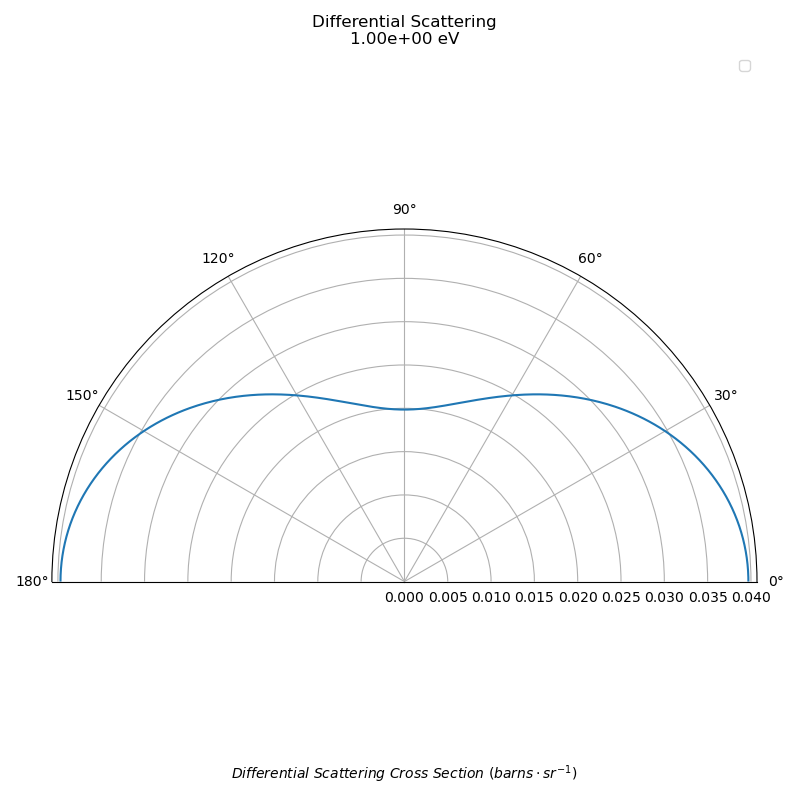

In [8]:
# This is the differential scattering for Free Electrons. 
# What do you notices about the directionality of scattering in the visible regime (~10 eV)?
# What about the X-ray regime (~10 keV)?
# What about the Gamma regime (~10 MeV)
# How does this compare to the free electron?
scattering_cross_section(None)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


interactive(children=(FloatSlider(value=0.0, description='logeV', max=8.0), Output()), _dom_classes=('widget-i…

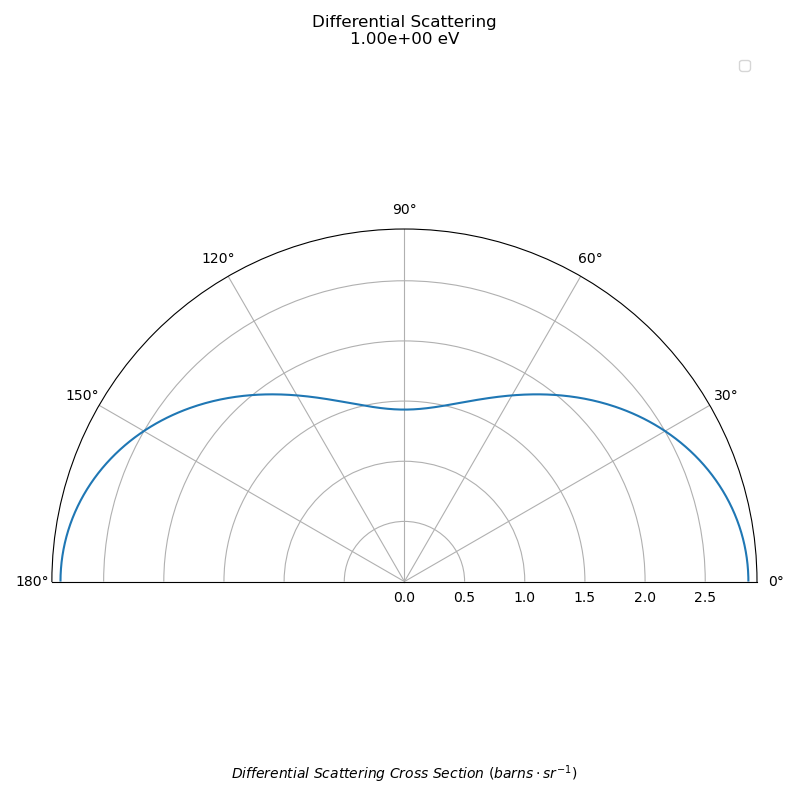

In [7]:
# This is the differential scattering for Free Electrons. 
# What do you notices about the directionality of scattering in the visible regime (~10 eV)?
# What about the X-ray regime (~10 keV)?
# What about the Gamma regime (~10 MeV)
# How does this compare to the free electron?
scattering_cross_section(6)

/tmp/ipykernel_140799/1755814848.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax = plt.pcolor(Xi[:,0].reshape((n,n)), Xi[:,1].reshape((n,n)), Zi, norm=norm)


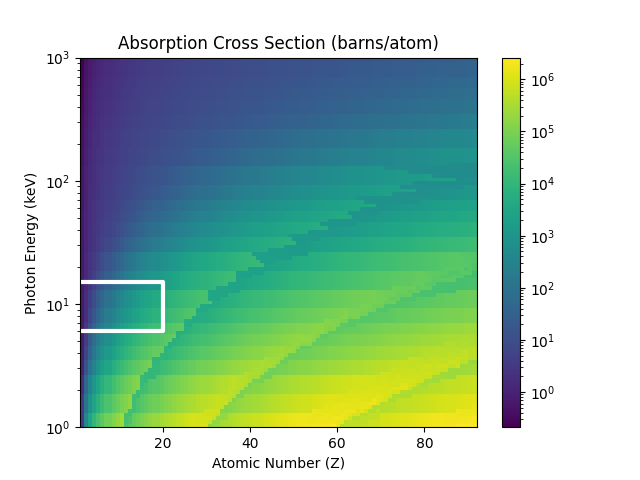

In [136]:
df = pd.read_csv('mass_coefficients.csv', names = ['', 'Energy', 'mu/rho', 'mu_en/rho', 'Z'], header=1)
df['Energy'] = df['Energy']*1000.

mass = pd.read_csv("atomic_mass.csv", delim_whitespace=True)
mass

df = df.join(mass.set_index('Z'), on='Z')

df['SIGMA'] = df['mu/rho']*df['Mass']/Avogadro

#This is nearest neighbor interpolation
ykey = 'Energy'
xkey = 'Z'
zkey = 'SIGMA'


X = df[xkey].values
Y = df[ykey].values
Z = df[zkey].values


n = 100
Zi = np.zeros((n, n))

Xi = np.dstack(np.meshgrid(
    np.linspace(X.min(), X.max(), n),
    np.logspace(0, 3, n)
))
Xi = Xi.reshape((n**2, 2))
Xo = np.vstack((X, Y)).T

idx = np.argmin(np.linalg.norm(Xi[:,None] - Xo, 2, 2), 1)
Zi  = Z[idx].reshape((n,n)) * 1e24

norm = mpl.colors.LogNorm(Zi.min(), Zi.max())

plt.figure()
ax = plt.pcolor(Xi[:,0].reshape((n,n)), Xi[:,1].reshape((n,n)), Zi, norm=norm)
plt.colorbar()
plt.title("Absorption Cross Section (barns/atom)")
plt.xlabel("Atomic Number (Z)")
plt.ylabel("Photon Energy (keV)")
plt.yticks(range(0, 100, 10))
xlim = plt.xlim()
plt.plot([0, 20, 20, 0], [6, 6, 15, 15], 'w', linewidth=3)
plt.xlim(xlim)
plt.yscale('log')
